<a href="https://colab.research.google.com/github/Norberto27/-IAAA2-DISTANCIA-A/blob/main/NRMU_TP_RL2_CartPole_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**Trabajo Práctico RL2: CartPole-v1**


**Alumno: NORBERTO RAUL MARTEARENA URQUIZA**


**Enlace Colab:** [LINK]  
**Enlace GitHub:** [LINK]

In [ ]:

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import random
import seaborn as sns

#**2.1 Detalles del entorno**

- **Observaciones**: vector de 4 floats:
  1. Posición del carrito ∈ [-2.4, 2.4]
  2. Velocidad del carrito
  3. Ángulo del poste ∈ [-12°,12°]
  4. Velocidad angular del poste
- **Acciones**: Discrete(2) ⇒ {0 = empujar a la izquierda, 1 = empujar a la derecha}
- **Recompensa**: +1 por cada paso que el poste se mantenga vertical
- **Terminación**: si |posición|>2.4 o |ángulo|>12° o ≥500 pasos


In [ ]:
# asegurar reproducibilidad
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
env = gym.make('CartPole-v1')

#**2.2 Función para visualizar la política**
# En CartPole, la política es un mapeo continuo ⇒ acción (0/1) por estado.
# Para Q-Tabular discretizamos y graficamos flechas en la grilla.

In [ ]:


# discretización de 4-d
bins = [
  np.linspace(-2.4,2.4,10), np.linspace(-3.0,3.0,10),
  np.linspace(-0.5,0.5,10), np.linspace(-3.5,3.5,10)
]
def discretize(obs):
  return tuple(np.digitize(obs[i],bins[i]) for i in range(4))

def plot_policy_tabular(policy, resolution=10):
  fig,ax = plt.subplots(5,5,figsize=(6,6))
  # Simplificación: visualize for first two dims
  grid = policy.reshape(resolution,resolution, -1)[:,:,0]
  for i in range(resolution):
    for j in range(resolution):
      a = grid[i,j]
      dx = -0.3 if a==0 else 0.3
      ax[i,j].arrow(0.5,0.5,dx,0,head_width=0.1)
      ax[i,j].axis('off')
  plt.suptitle('Política Q-Tabular')
  plt.show()



#**2.3 Entrenamiento de agentes**
# Adaptaciones desde TP1 (FrozenLake) para CartPole:
# Espacio de estados continuo** → usamos `np.digitize` en 4 dimensiones en lugar de index único.
#**Acciones** = 2 en vez de 4: ajustamos selectores de acción.
#**Duración de episodio**: máximo 500 vs. 100 pasos → adaptamos bucles.
#**Input de red DQN**: vector 4D en lugar de one-hot de tamaño 16.
#**Salida de red**: tamaño 2 en vez de 4.

#**2.3.1 Política Aleatoria**

In [ ]:
class PoliticaAleatoria:
  def __init__(self,n): self.n=n
  def seleccionar(self,obs): return np.random.randint(self.n)
  def entrenar(self,env,episodios=1000):
    recomp=[]
    for _ in range(episodios):
      o,_=env.reset(); done=False; r_tot=0
      while not done:
        a=self.seleccionar(o)
        o,r,done,_,_=env.step(a)
        r_tot+=r
      recomp.append(r_tot)
    return recomp

tag=PoliticaAleatoria(env.action_space.n)
r_a = tag.entrenar(env,2000)


#**2.3.2   Q-Learning Tabular**

In [ ]:
class QLearningTabular:
  def __init__(self,lr=0.1,gamma=0.99,eps=1.0):
    dims=[len(b)+1 for b in bins]+[env.action_space.n]
    self.Q=np.zeros(dims)
    self.lr, self.gamma = lr,gamma
    self.eps, self.eps_min, self.decay=eps,0.01,0.995
  def seleccionar(self,obs,train=True):
    s=discretize(obs)
    if train and random.random()<self.eps: return random.randrange(2)
    return np.argmax(self.Q[s])
  def update(self,o,a,r,o2,done):
    s,s2=discretize(o),discretize(o2)
    tgt = r if done else r + self.gamma*np.max(self.Q[s2])
    self.Q[s+(a,)] += self.lr*(tgt-self.Q[s+(a,)])
  def entrenar(self,env,epis=2000):
    rec=[]
    for _ in range(epis):
      o,_=env.reset();done=False;r_tot=0
      while not done:
        a=self.seleccionar(o)
        o2,r,done,_,_=env.step(a)
        self.update(o,a,r,o2,done)
        self.eps=max(self.eps*self.decay,self.eps_min)
        o,r_tot=o2,r_tot+r
      rec.append(r_tot)
    return rec

qag=QLearningTabular()
r_q = qag.entrenar(env,2000)

#**2.3.3 DQN**

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, lr=1e-3, gamma=0.99, eps=1.0):
        self.gamma = gamma
        self.eps = eps
        self.decay = 0.995
        self.eps_min = 0.01
        # Redes Q y target en device
        self.net = DQN().to(device)
        self.tgt = DQN().to(device)
        self.tgt.load_state_dict(self.net.state_dict())
        self.opt = optim.Adam(self.net.parameters(), lr=lr)
        # Experience Replay Buffer
        self.mem = deque(maxlen=5000)
        self.bs = 32
        self.steps = 0

    def seleccionar(self, o, train=True):
        # Convierte estado a tensor y mueve a device
        if train and random.random() < self.eps:
            return random.randrange(env.action_space.n)
        state = torch.FloatTensor(o).unsqueeze(0).to(device)
        with torch.no_grad():
            q = self.net(state)
        return int(q.argmax().cpu().numpy())

    def remember(self, o, a, r, o2, d):
        self.mem.append((o, a, r, o2, d))

    def replay(self):
        if len(self.mem) < self.bs:
            return
        batch = random.sample(self.mem, self.bs)
        states, actions, rewards, next_states, dones = zip(*batch)
        # Convertir y mover a device
        states = torch.FloatTensor(np.array(states)).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        dones = torch.BoolTensor(dones).to(device)

        # Q(s,a)
        q_values = self.net(states).gather(1, actions.unsqueeze(1)).squeeze()
        # Target Q
        with torch.no_grad():
            next_q = self.tgt(next_states).max(1)[0]
            target_q = rewards + self.gamma * next_q * (~dones)

        # Pérdida y backprop
        loss = F.mse_loss(q_values, target_q)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        # Actualizar target
        self.steps += 1
        if self.steps % self.bs == 0:
            self.tgt.load_state_dict(self.net.state_dict())

    def entrenar(self, env, epis=1000):
        rec = []
        for _ in range(epis):
            o, _ = env.reset()
            done = False
            r_tot = 0
            while not done:
                a = self.seleccionar(o)
                o2, r, done, _, _ = env.step(a)
                r_tot += r
                self.remember(o, a, r, o2, done)
                self.replay()
                self.eps = max(self.eps * self.decay, self.eps_min)
                o = o2
            rec.append(r_tot)
        return rec

# Entrenamiento DQN con GPU (si está disponible)
dqn = DQNAgent(lr=1e-3, gamma=0.99, eps=1.0)
r_d = dqn.entrenar(env, epis=2000)

#**2.4 Comparación de desempeño**

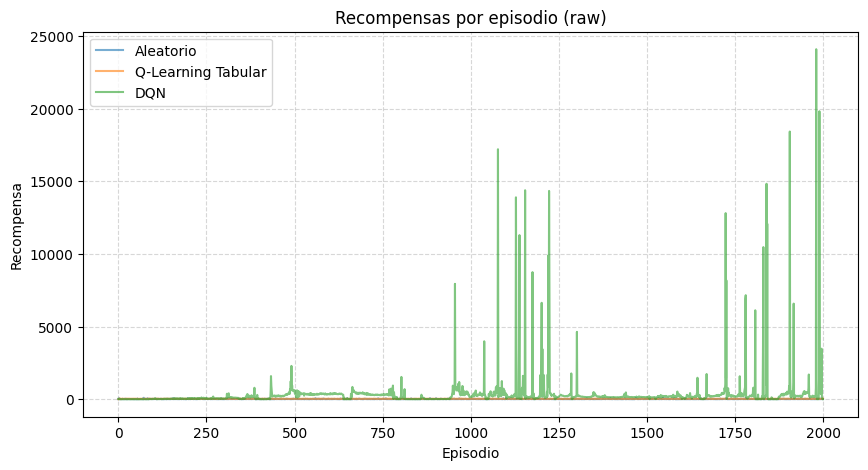

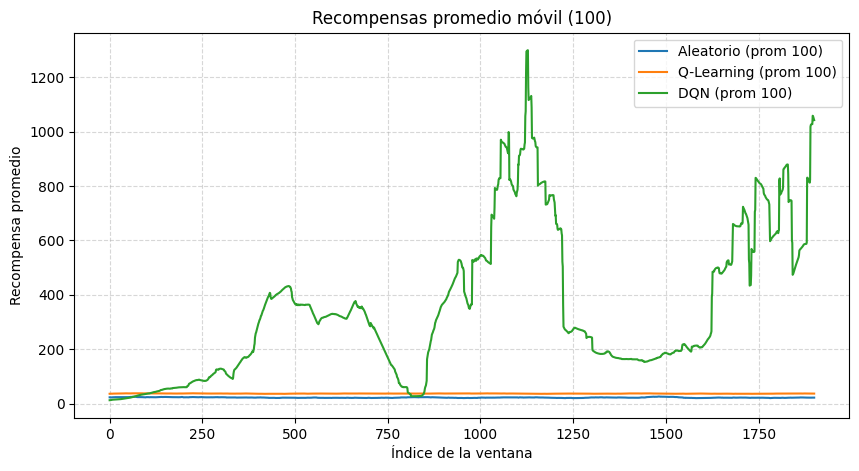

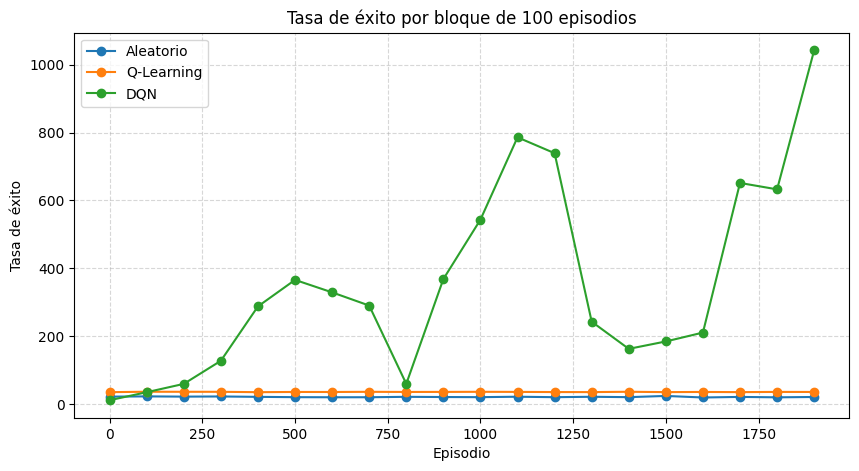

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Serie de recompensas crudas
plt.figure(figsize=(10,5))
plt.plot(r_a, label='Aleatorio', alpha=0.6)
plt.plot(r_q, label='Q-Learning Tabular', alpha=0.6)
plt.plot(r_d, label='DQN', alpha=0.6)
plt.title('Recompensas por episodio (raw)')
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Promedio móvil (window=100)
def moving_average(x, w=100):
    return np.convolve(x, np.ones(w)/w, mode='valid')

ma_a = moving_average(r_a,100)
ma_q = moving_average(r_q,100)
ma_d = moving_average(r_d,100)

plt.figure(figsize=(10,5))
plt.plot(ma_a, label='Aleatorio (prom 100)')
plt.plot(ma_q, label='Q-Learning (prom 100)')
plt.plot(ma_d, label='DQN (prom 100)')
plt.title('Recompensas promedio móvil (100)')
plt.xlabel('Índice de la ventana')
plt.ylabel('Recompensa promedio')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Tasa de éxito en bloques de 100 episodios
def block_success_rate(r, block=100):
    return [np.mean(r[i:i+block]) for i in range(0, len(r), block)]

b_a = block_success_rate(r_a)
b_q = block_success_rate(r_q)
b_d = block_success_rate(r_d)
idx = np.arange(len(b_a)) * 100

plt.figure(figsize=(10,5))
plt.plot(idx, b_a, marker='o', label='Aleatorio')
plt.plot(idx, b_q, marker='o', label='Q-Learning')
plt.plot(idx, b_d, marker='o', label='DQN')
plt.title('Tasa de éxito por bloque de 100 episodios')
plt.xlabel('Episodio')
plt.ylabel('Tasa de éxito')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



### 2.5 Conclusiones y referencia
- Adaptar TP1 (discreto) a espacio continuo implicó discretización.
- Q-Learning tabular funciona pero DQN es más robusto.
- Dificultades: elegir bins, estabilidad de red.
- Fuentes: Sutton & Barto, Gym doc, PyTorch tutorial.
